In [69]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white', figsize=(12,12))

scanpy==1.9.6 anndata==0.10.3 umap==0.5.5 numpy==1.24.3 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.3.0 statsmodels==0.14.0 igraph==0.10.8 louvain==0.8.1 pynndescent==0.5.11


# 1. Data Acquisition

In [3]:
adata1 = sc.read_csv('DATA/Muscle_1_Counts.csv.gz').T
adata2 = sc.read_csv('DATA/Muscle_2_Counts.csv.gz').T
adata3 = sc.read_csv('DATA/Muscle_3_Counts.csv.gz').T
adata4 = sc.read_csv('DATA/Muscle_4_Counts.csv.gz').T

In [4]:
adata = anndata.concat([adata1,adata2,adata3,adata4])

In [5]:
adata

AnnData object with n_obs × n_vars = 2876 × 15406

normalizing counts per cell
    finished (0:00:00)


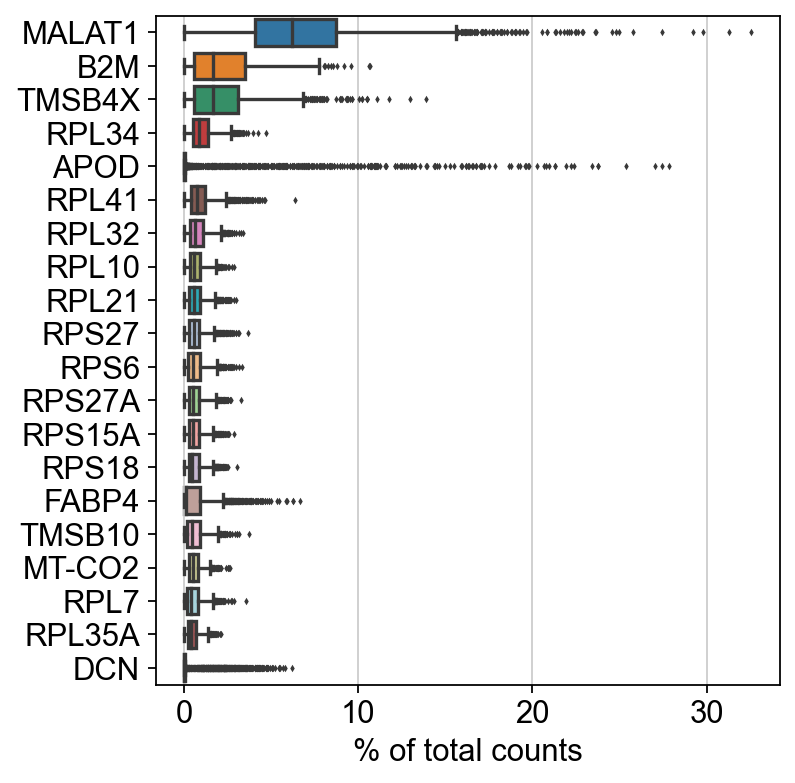

In [6]:
sc.pl.highest_expr_genes(adata, n_top=20, )

# 2. Data Pre-processing

In [7]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 352 genes that are detected in less than 3 cells


In [8]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

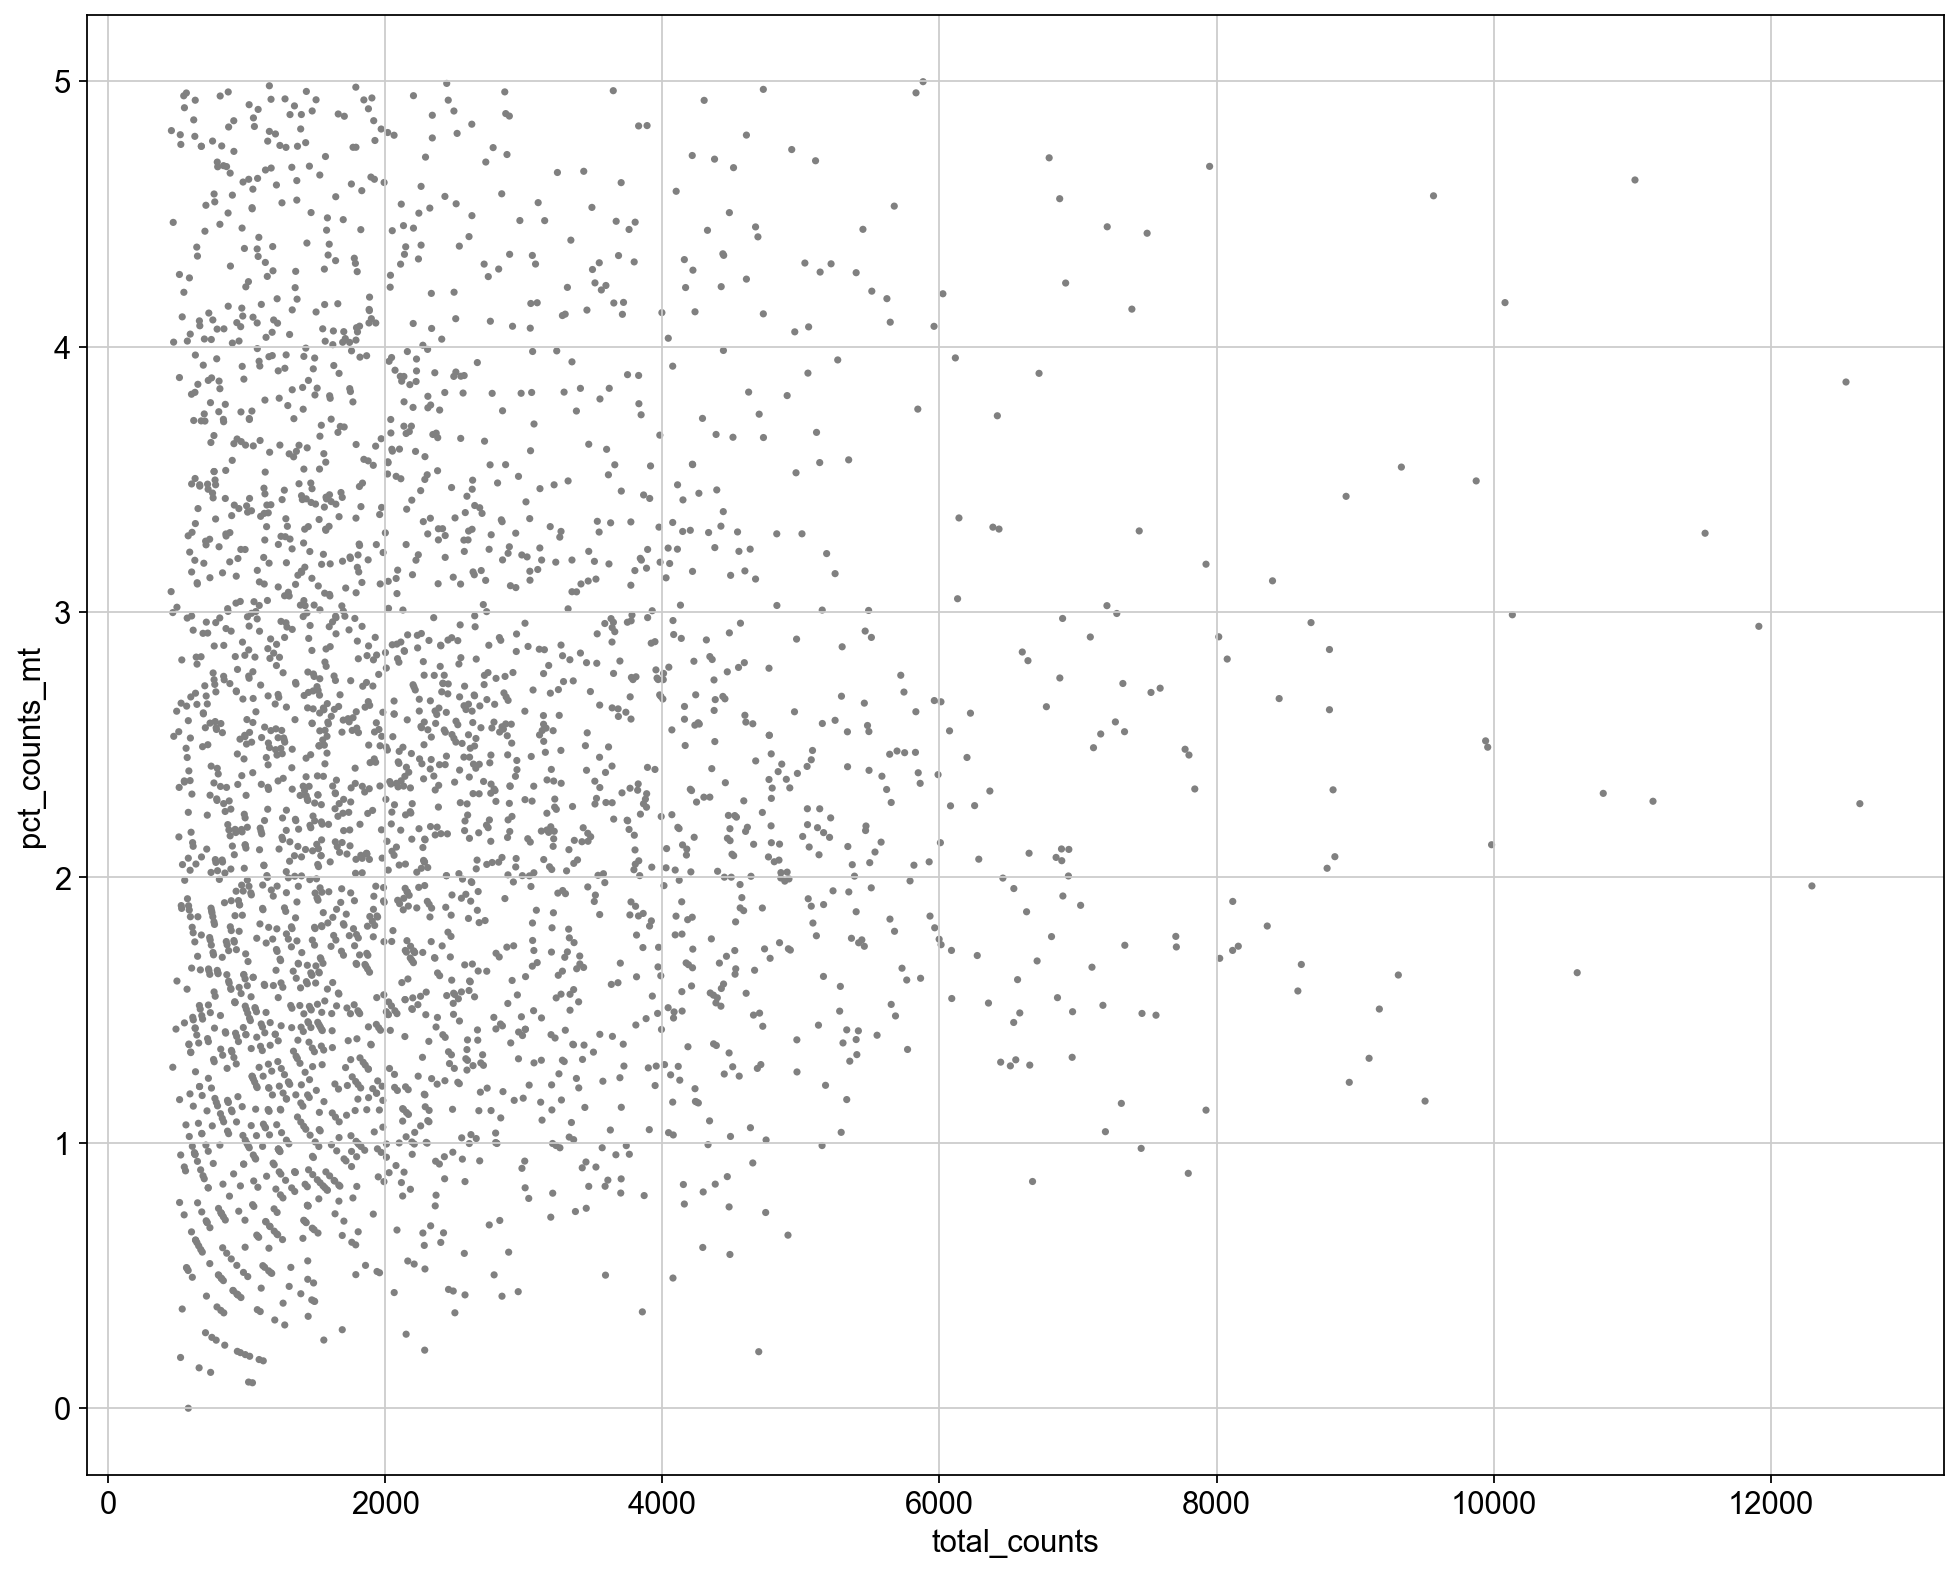

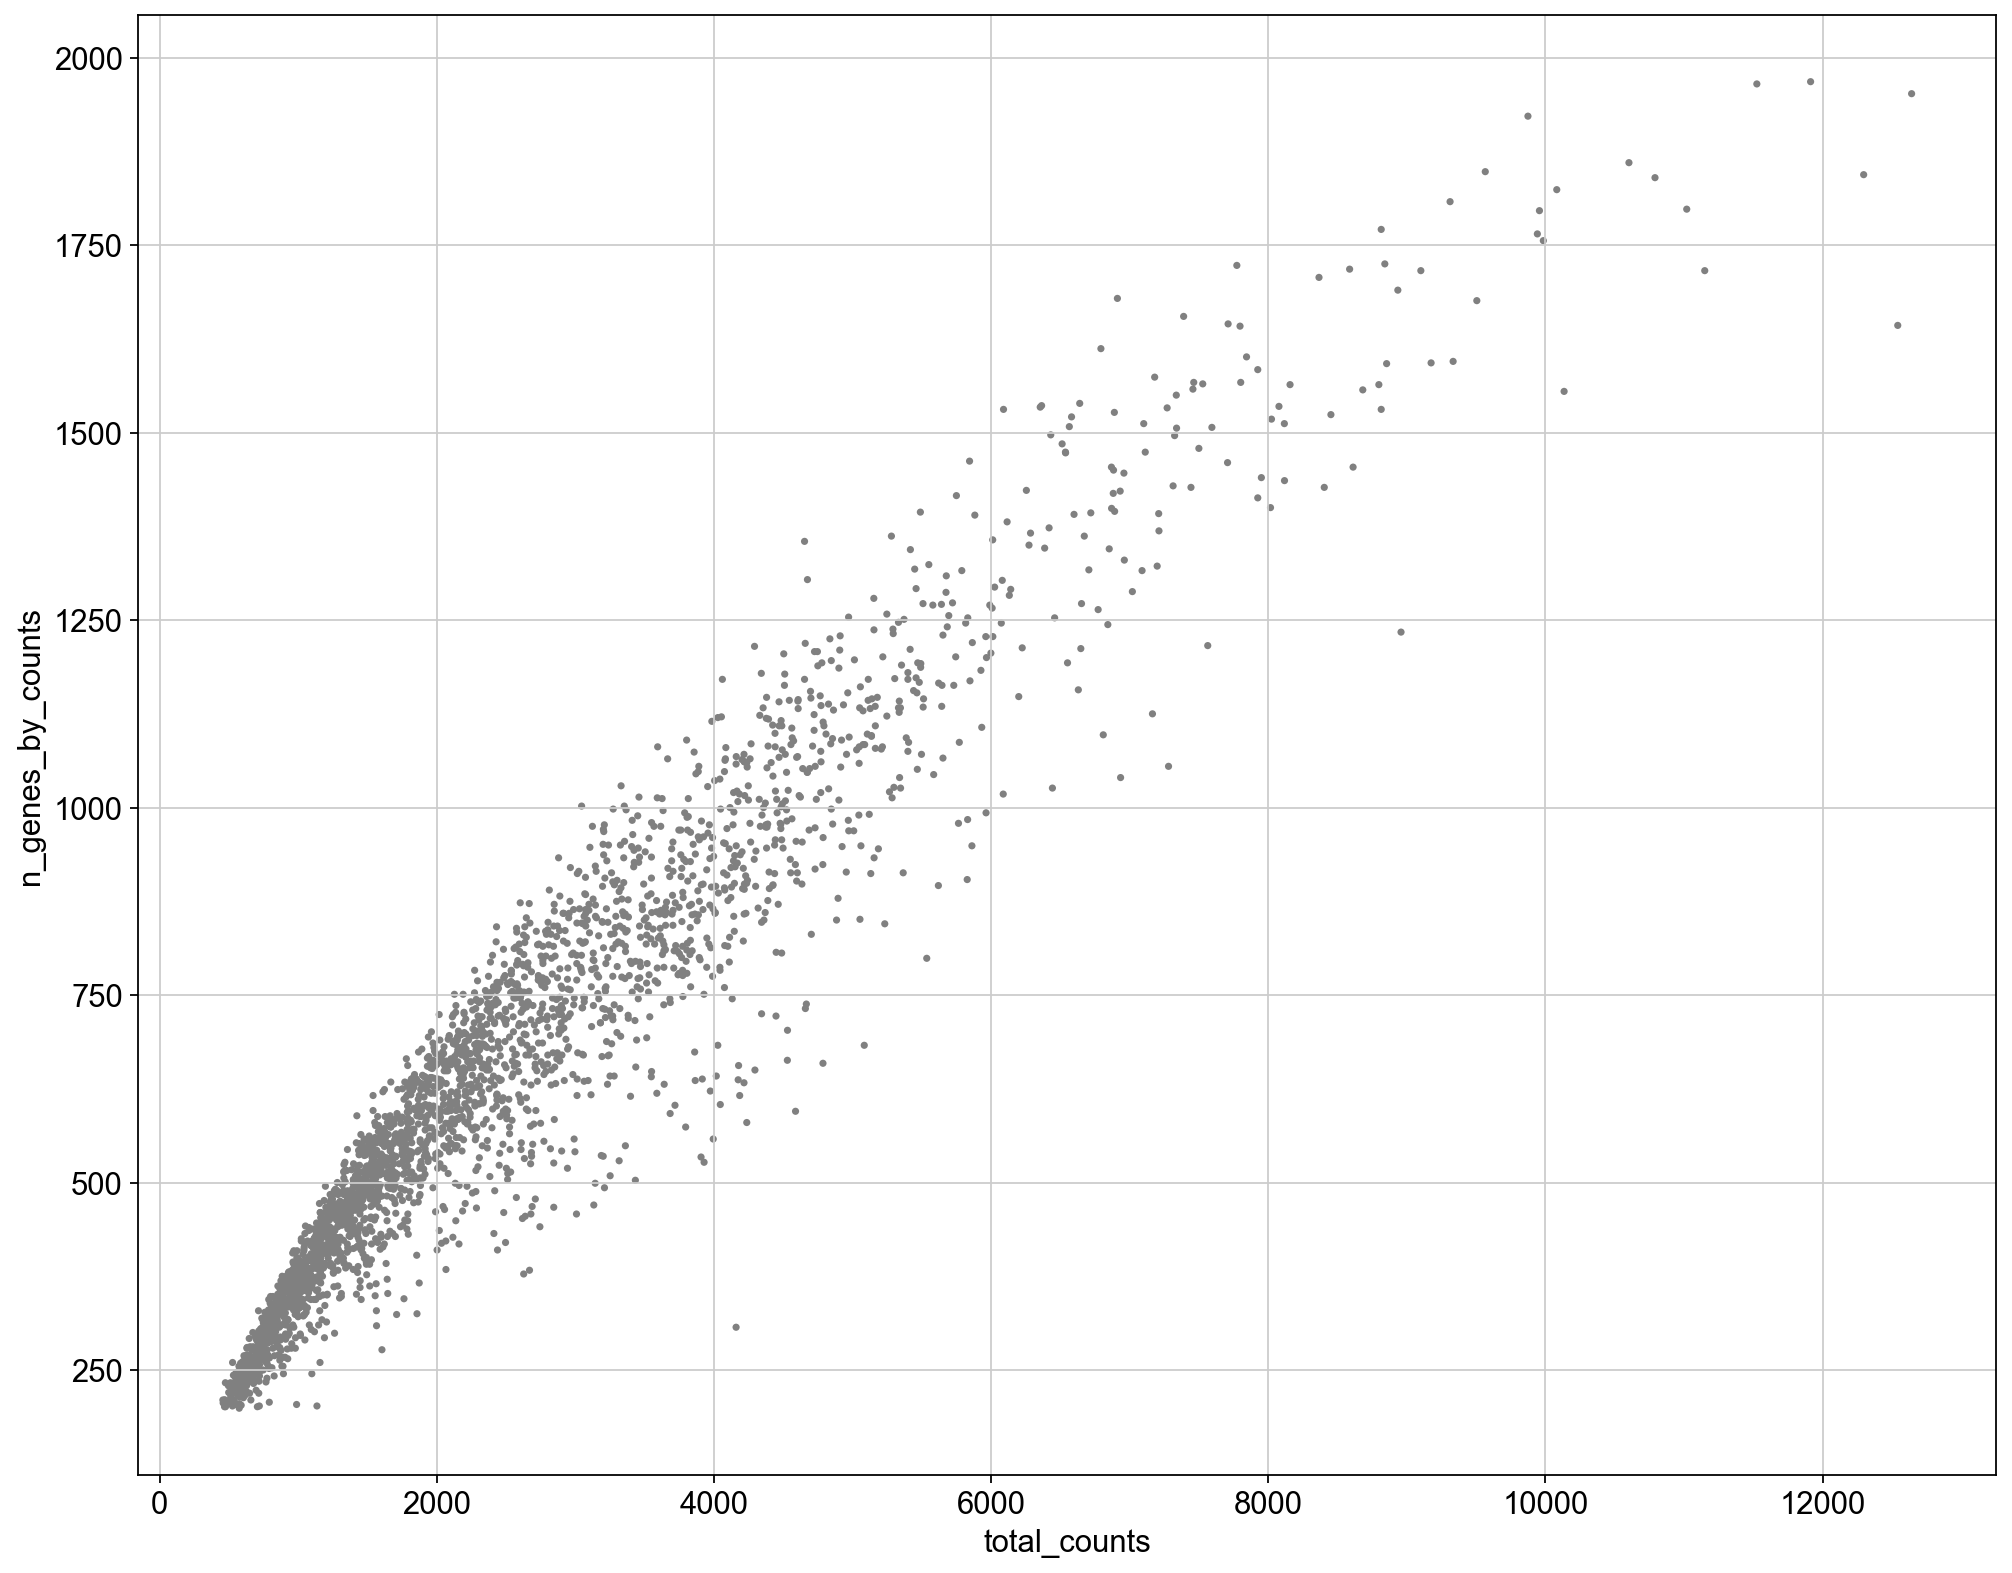

In [9]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [10]:
adata.obs.sort_values('n_genes_by_counts')

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
3_TTGACTTAGGGTTTCT,200,199,573.0,11.0,1.919721
3_TACTTGTAGATGGGTC,201,201,474.0,12.0,2.531646
2_TTGAACGCAGGCTCAC,202,201,704.0,23.0,3.267045
2_ACGGGTCAGACTAGAT,201,201,467.0,14.0,2.997859
1_CGTGTAAAGCGGCTTC,202,202,1134.0,40.0,3.527337
...,...,...,...,...,...
3_TCTCTAACAAAGGTGC,1860,1860,10603.0,174.0,1.641045
2_TTGTAGGAGTTGTAGA,1927,1922,9874.0,345.0,3.494025
2_GTGCTTCTCGGCGCAT,1953,1952,12643.0,288.0,2.277940
2_GGACATTTCTGCCCTA,1967,1965,11526.0,380.0,3.296894


In [11]:
sc.pp.filter_cells(adata, min_genes=200)

filtered out 1 cells that have less than 200 genes expressed


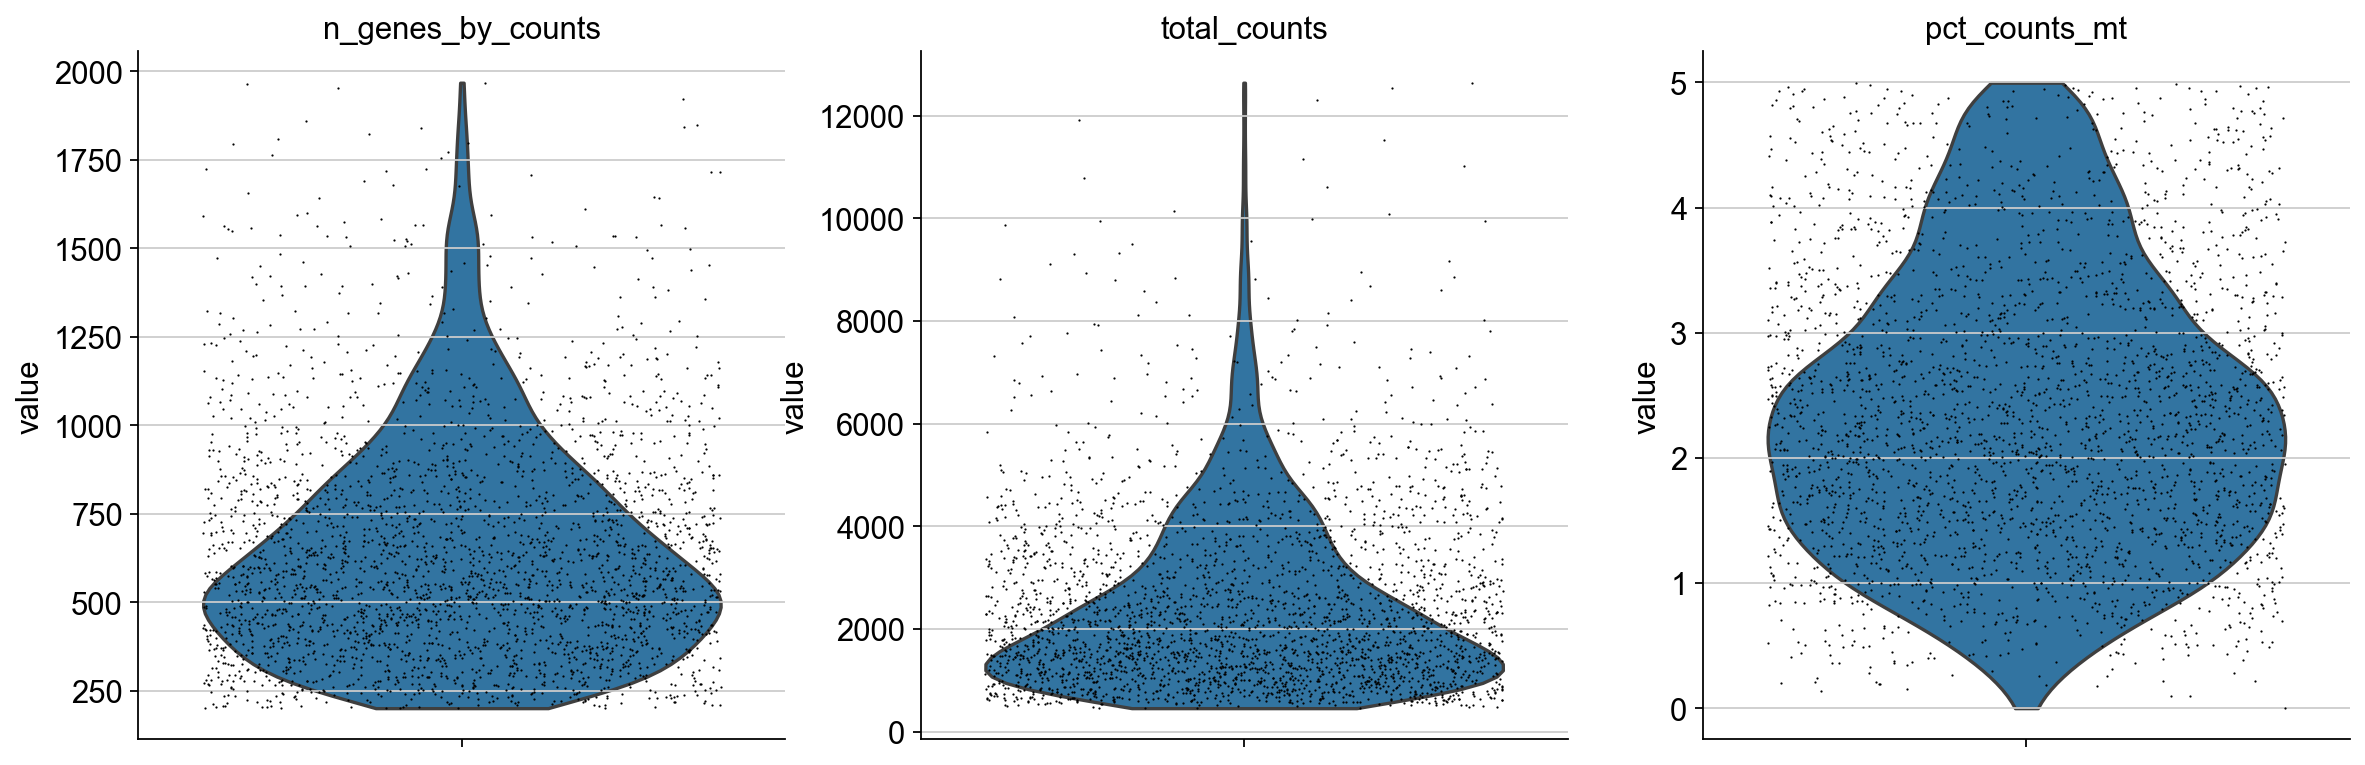

In [12]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [13]:
upper_lim=np.quantile(adata.obs.n_genes_by_counts.values, .98)
lower_lim=np.quantile(adata.obs.n_genes_by_counts.values, .02)
print(f'{lower_lim} to {upper_lim}')

226.48000000000002 to 1507.52


In [14]:
adata = adata[adata.obs.n_genes_by_counts < upper_lim]

In [15]:
adata = adata[adata.obs.pct_counts_mt < 5]

In [16]:
adata.X.sum(axis=1)

array([ 765., 1150., 5075., ..., 1354.,  904., 2779.], dtype=float32)

In [17]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/Users/jacinthangelina/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [18]:
adata.X.sum(axis=1)

array([10000., 10000., 10000., ..., 10000., 10000., 10000.], dtype=float32)

In [19]:
sc.pp.log1p(adata)

In [20]:
adata.X.sum(axis=1)

array([ 985.5205, 1310.7546, 2073.8965, ..., 1545.4257,  877.2418,
       1777.1321], dtype=float32)

In [21]:
adata.raw = adata

In [22]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [23]:
adata.var

,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm
RP11-34P13.7,3,False,3,0.002086,99.895688,6.0,False,0.011729,2.563701,0.329962
AP006222.2,83,False,83,0.049026,97.114047,141.0,False,0.172440,2.174107,-0.780624
RP4-669L17.10,6,False,6,0.002086,99.791377,6.0,False,0.005650,1.221640,-3.495755
RP11-206L10.3,7,False,7,0.004172,99.756606,12.0,False,0.012242,2.197123,-0.715016
RP11-206L10.2,4,False,4,0.002782,99.860918,8.0,False,0.017453,2.607246,0.454093
...,...,...,...,...,...,...,...,...,...,...
AL592183.1,451,False,451,0.289986,84.318498,834.0,False,0.857287,2.579122,-0.176778
AL354822.1,26,False,26,0.011822,99.095967,34.0,True,0.082959,2.793280,0.984408
KIR2DL2,4,False,4,0.001391,99.860918,4.0,False,0.007936,1.753095,-1.980775
PNRC2.1,3,False,3,0.001043,99.895688,3.0,False,0.004830,1.622671,-2.352565


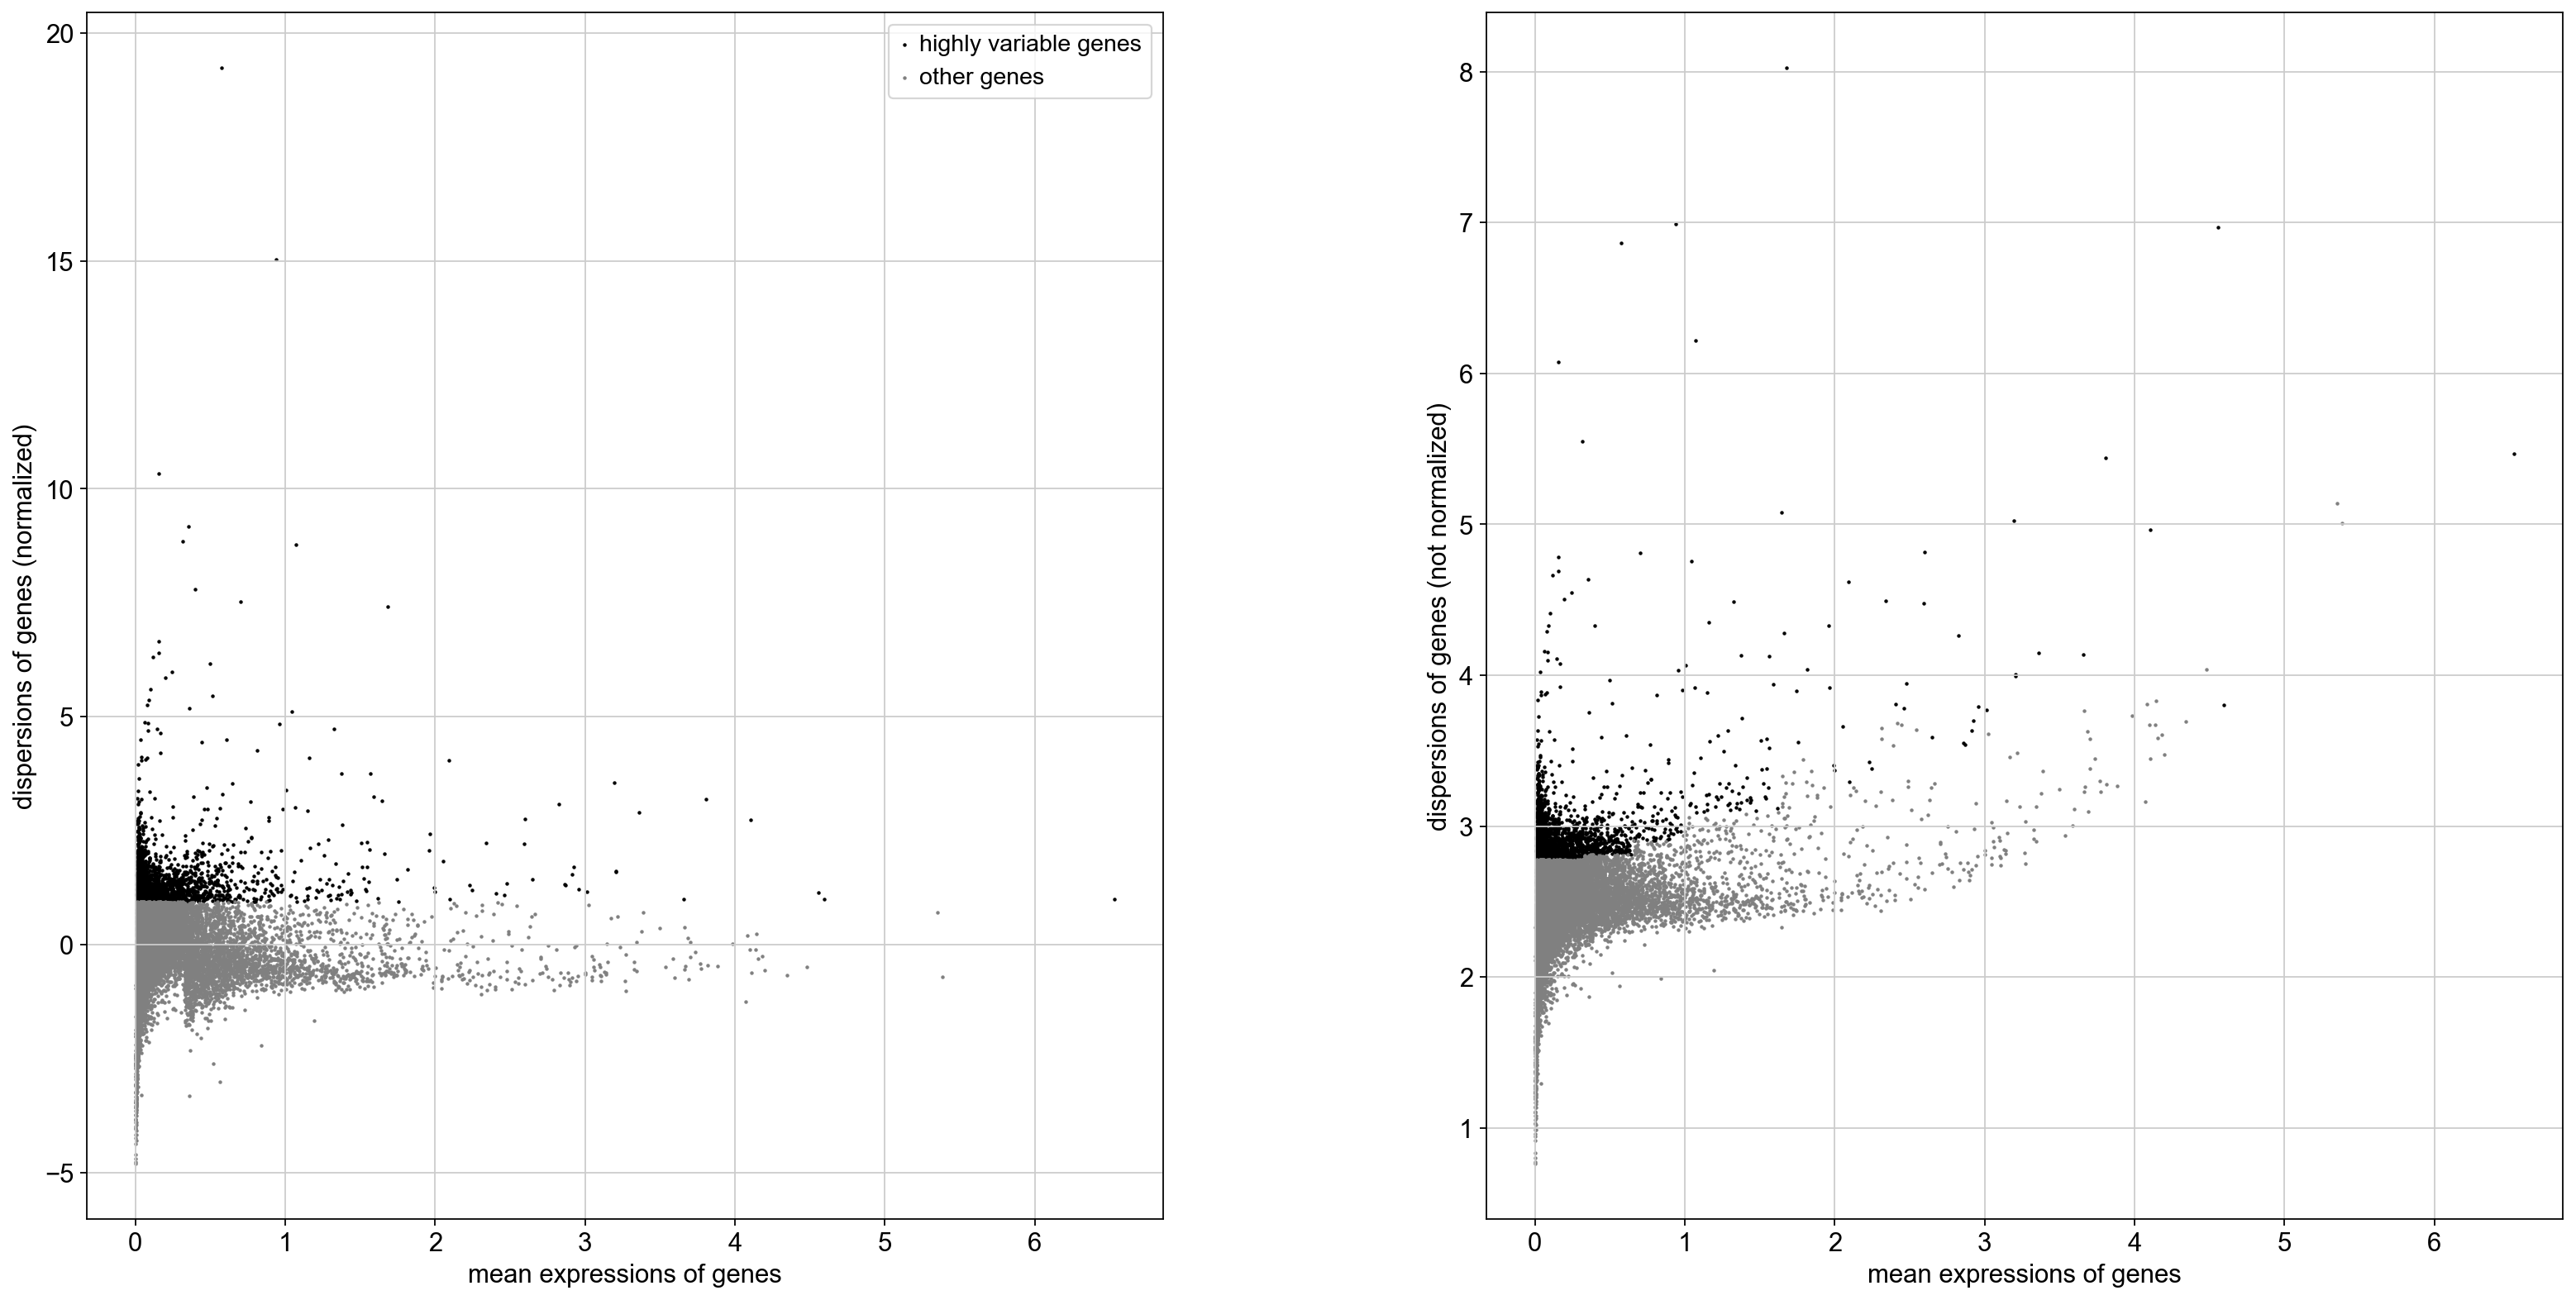

In [24]:
sc.pl.highly_variable_genes(adata)

In [25]:
adata = adata[:, adata.var.highly_variable]

In [26]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:00:02)


In [27]:
sc.pp.scale(adata, max_value=10)

# 3. Clustering

In [28]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)


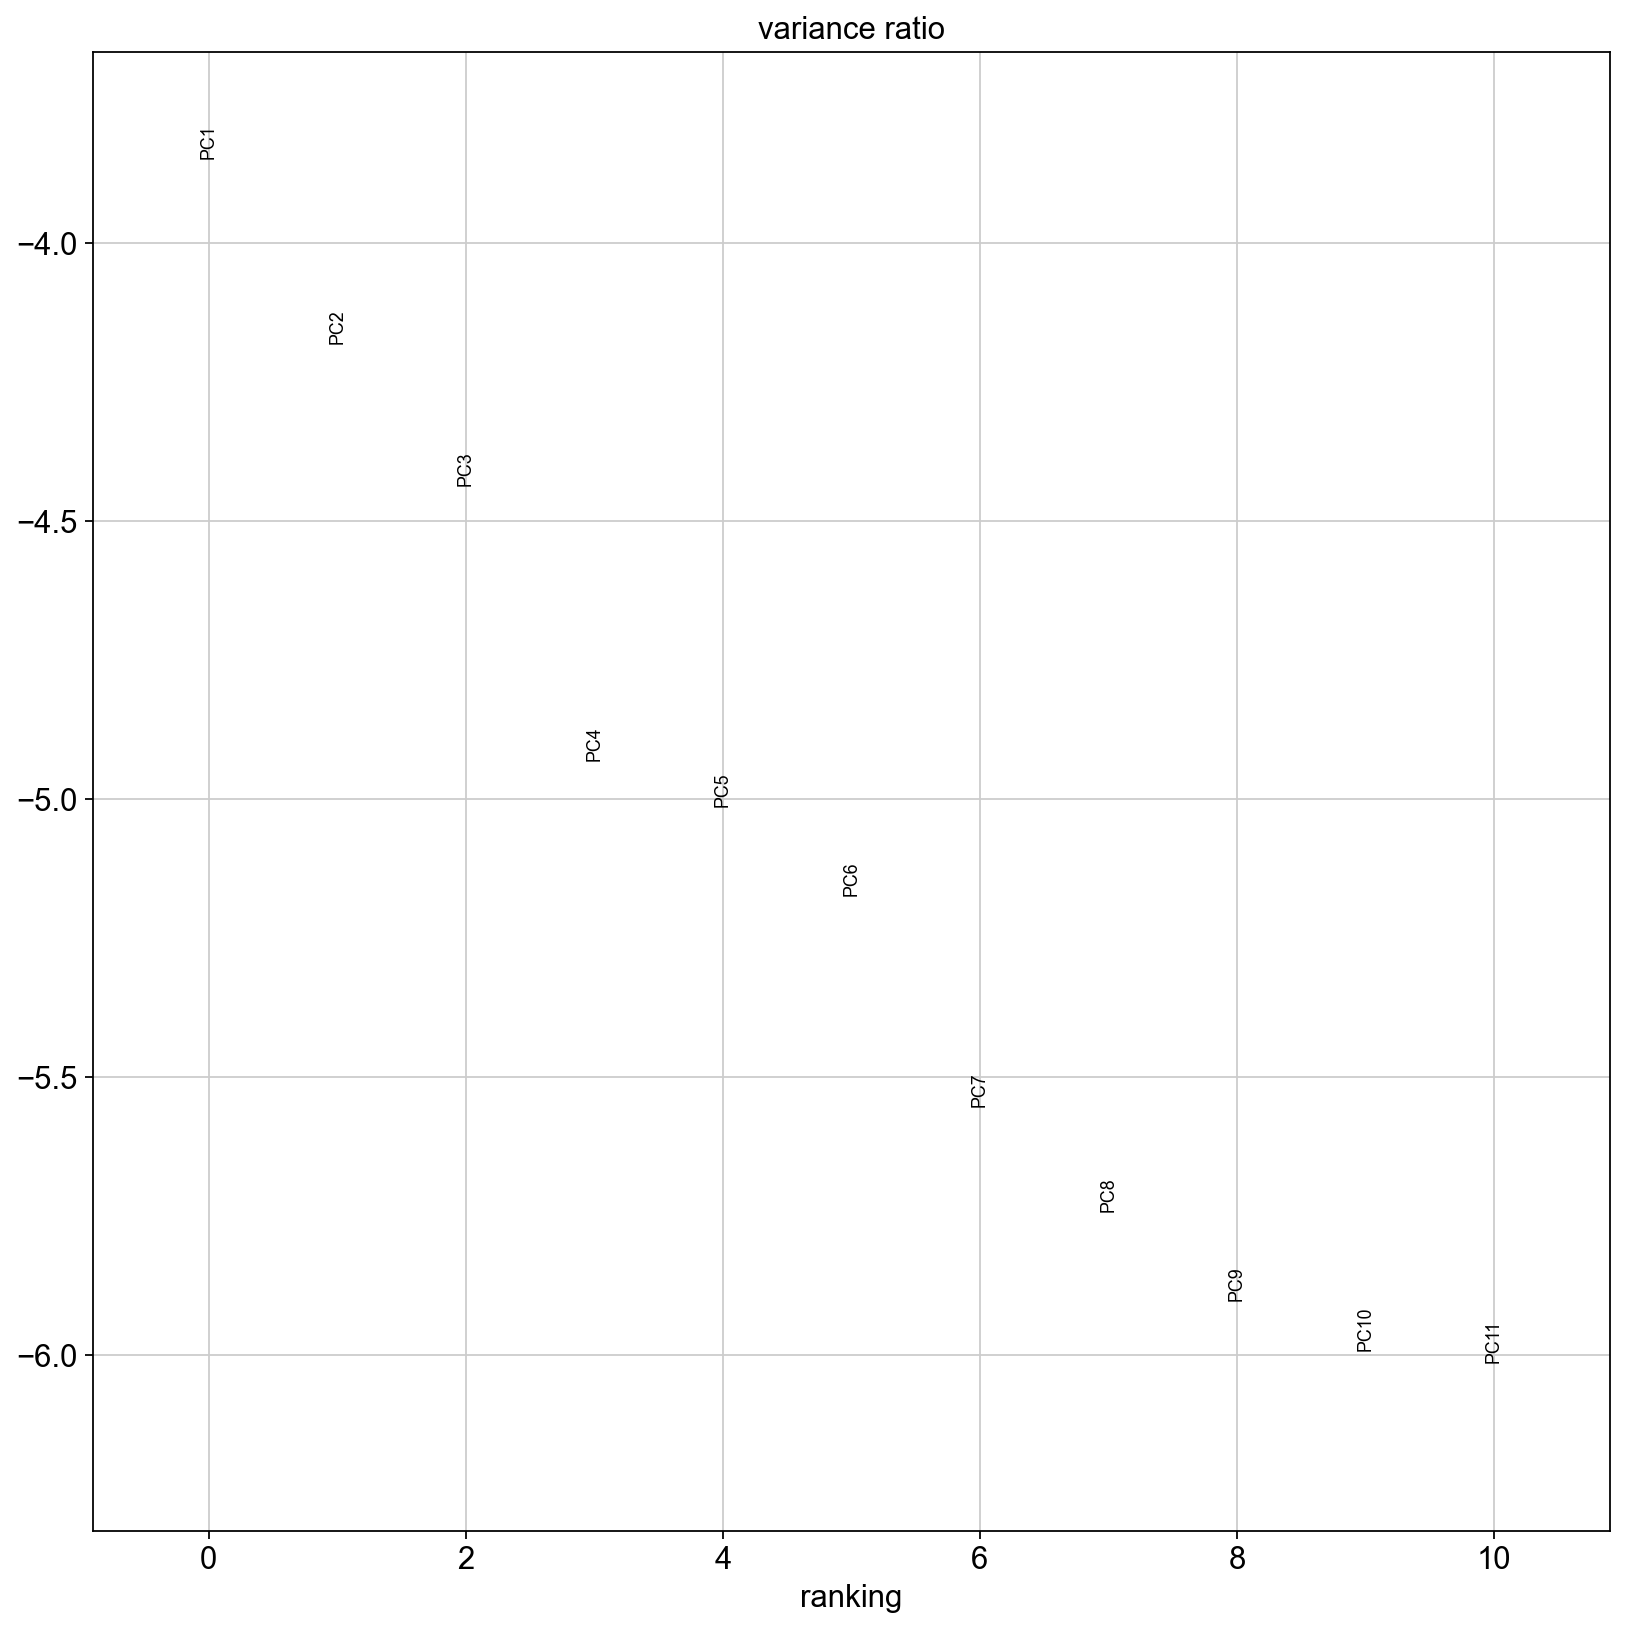

In [29]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=10)

In [30]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


In [31]:
sc.tl.tsne(adata, n_pcs=10, perplexity=25, random_state=0, learning_rate=1000)

computing tSNE
    using 'X_pca' with n_pcs = 10
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:11)


In [36]:
sc.tl.leiden(adata, key_added="clusters", resolution=0.25)

running Leiden clustering
    finished: found 11 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/jacinthangelina/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


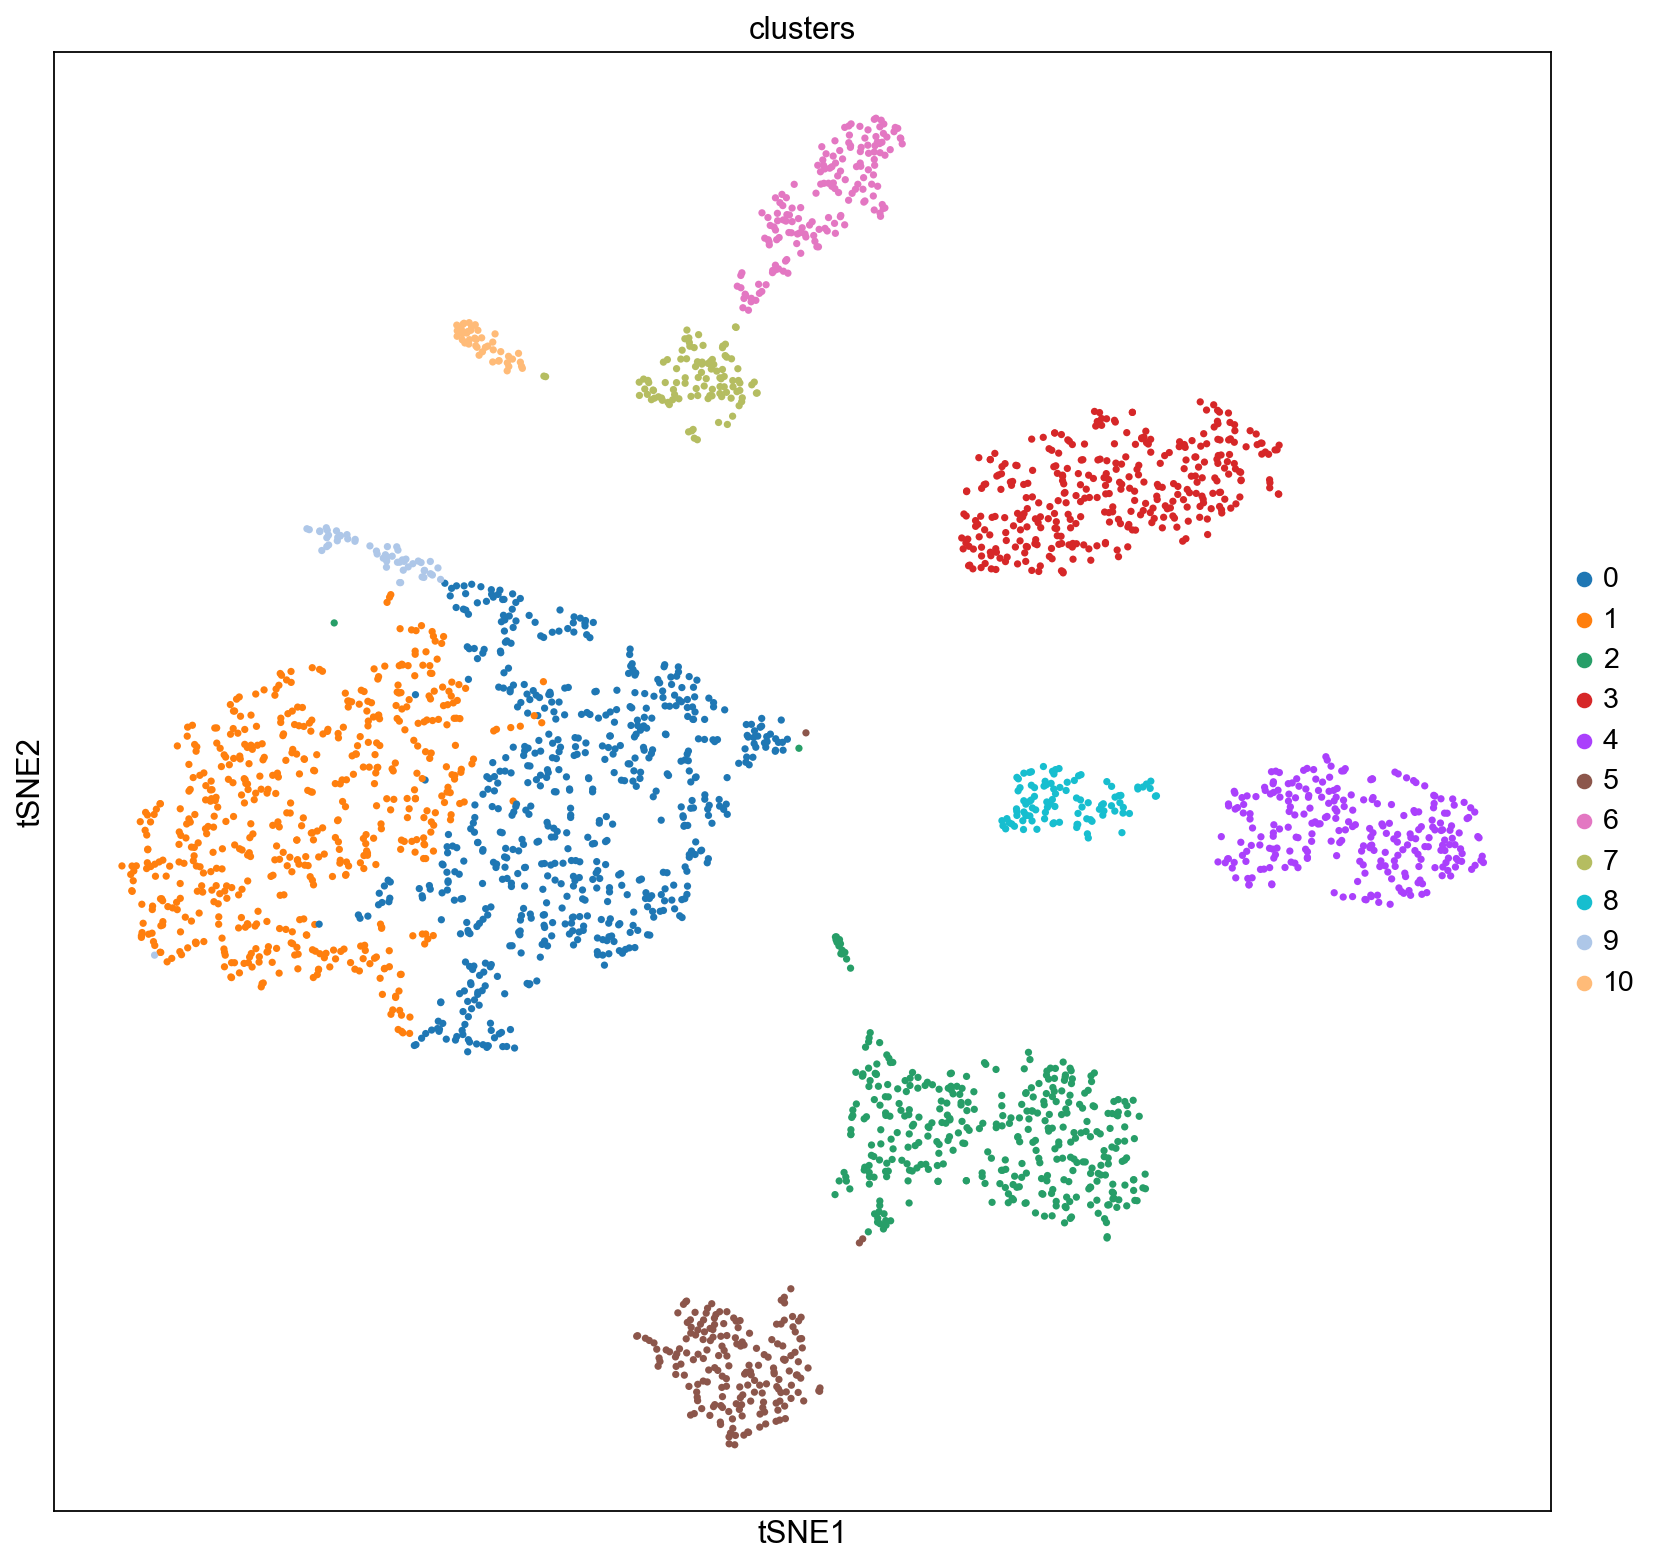

In [37]:
sc.pl.tsne(adata, color="clusters", cmap="tab20")

/Users/jacinthangelina/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


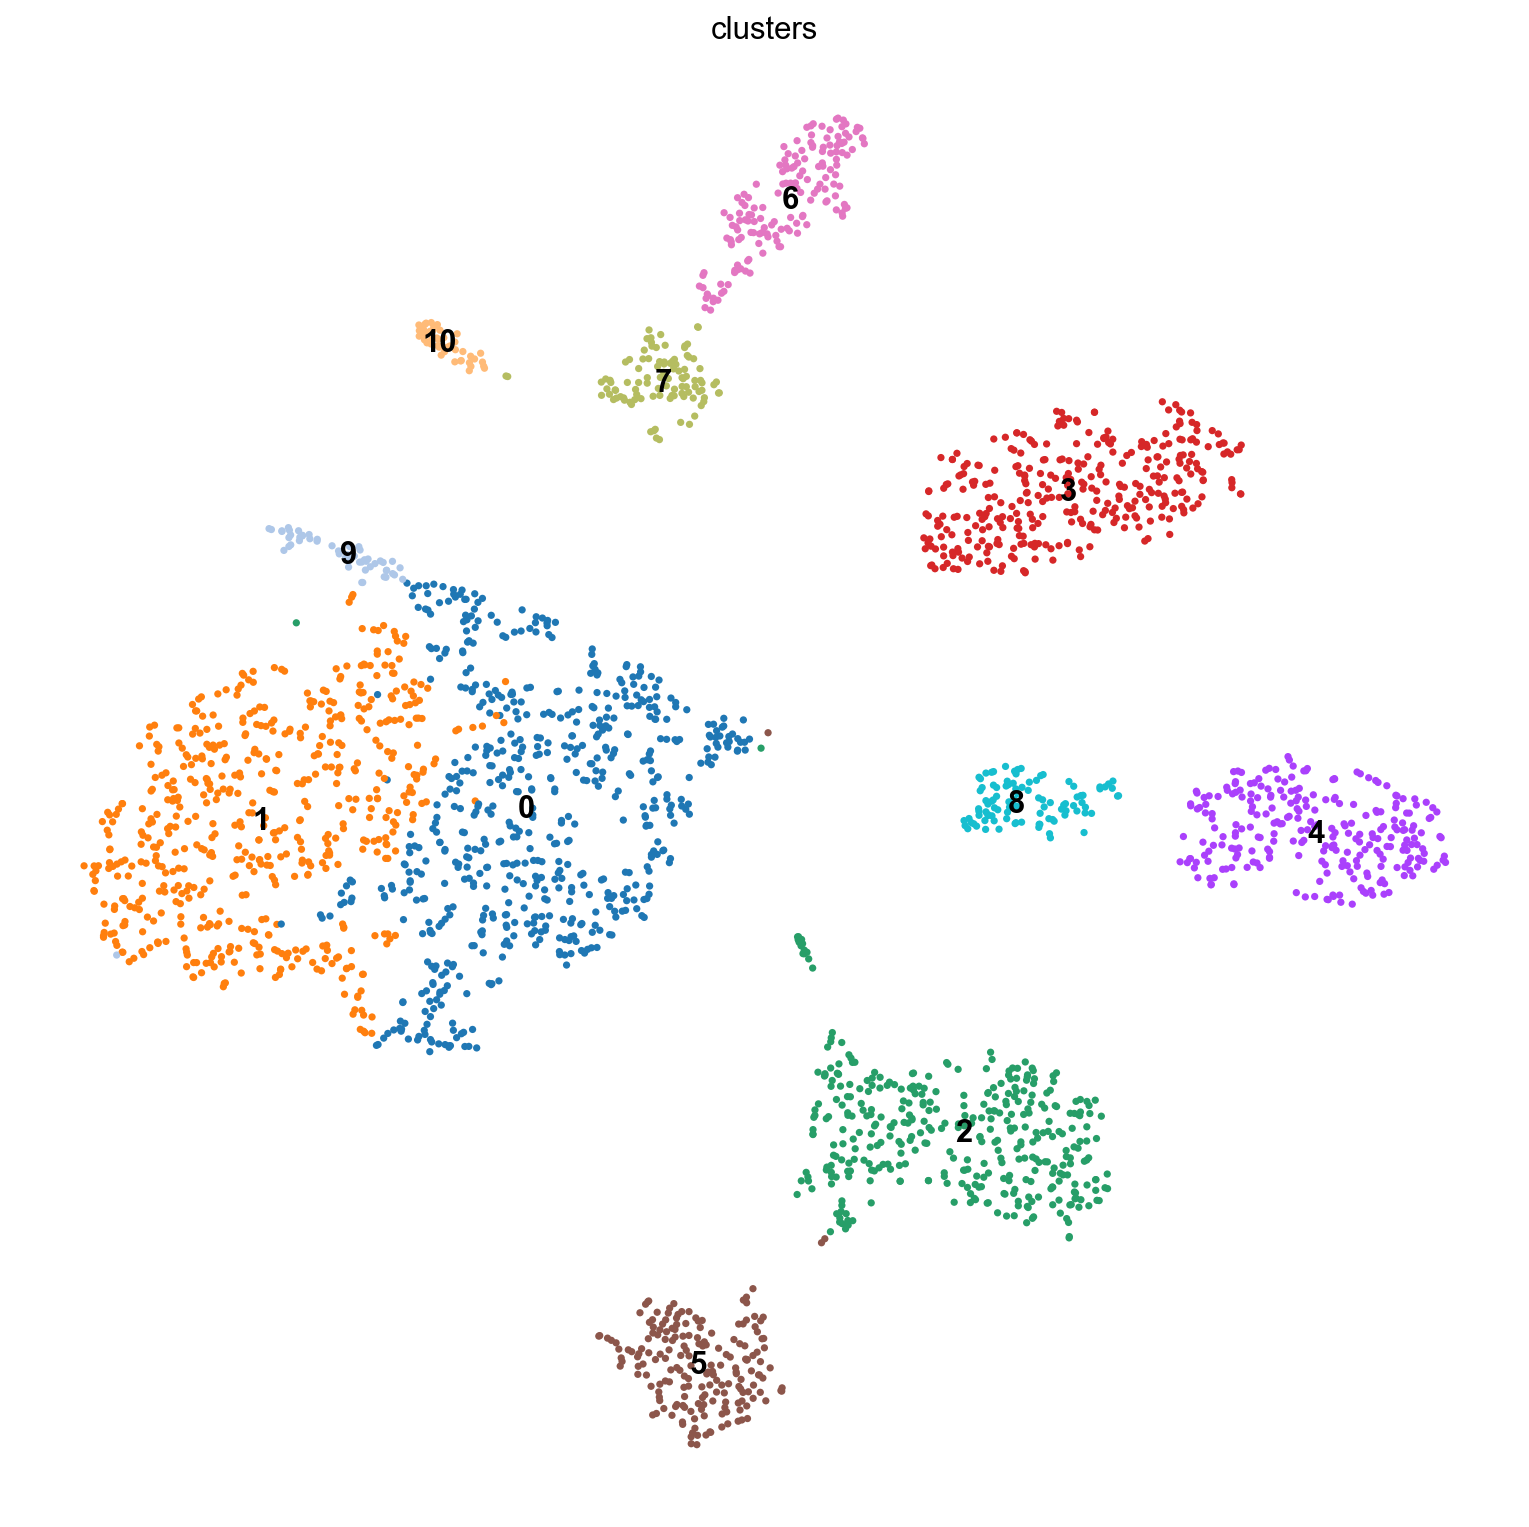

In [40]:
sc.pl.tsne(adata, color='clusters', frameon=False, legend_loc='on data')

In [110]:
marker_genes_dict = {
    'Endothelial Cells': ['VWF', 'AQP1','ITGA6'],
    'Endothelial Cells 1': ['CD93', 'TM4SF1','IGF2'],
    'LUM+ FAP Cells': ['COL15A1', 'APOD','LUM'],
    'Satellite Cells': ['CXCL14', 'ALDH1A1','SPRY1'],
    'Pericytes': ['TIMP3','COL3A1','IGFBP7'],
    'FBN1+ FAP Cells': ['DCN','CFD','C1S'],
    'NK Cells': ['CCL4','NKG7','GNLY'],
    'PCV Endothelial Cells': ['AQP1', 'CD74','AC011526.1'],
    'T and B Cells': ['ETS1', 'GMFG','TSC22D3'],
    'Smooth Muscle Cells': ['COX4I2', 'MYL9','ACTA2'],
    'Myeloid Cells': ['FCER1G', 'TYROBP','C1orf162'],
}

categories: 0, 1, 2, etc.
var_group_labels: Endothelial Cells, Endothelial Cells 1, LUM+ FAP Cells, etc.


/Users/jacinthangelina/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


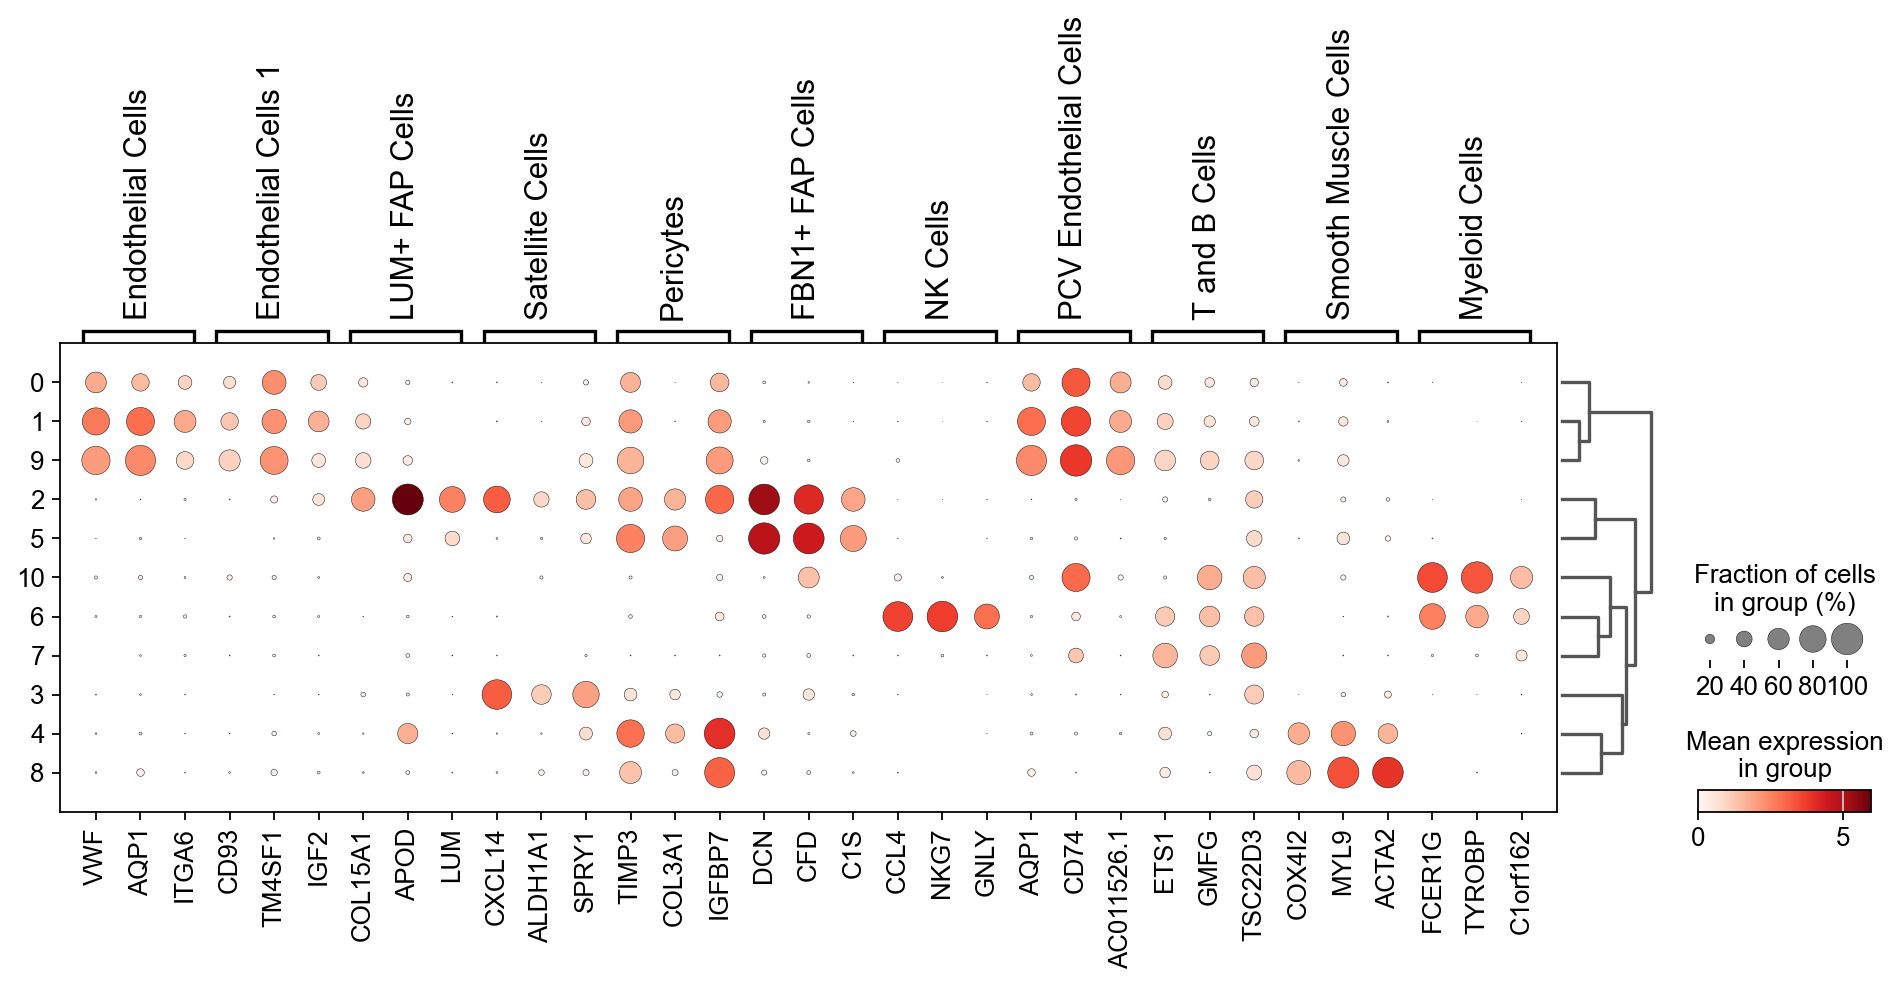

In [111]:
sc.pl.dotplot(adata, marker_genes_dict, 'clusters', dendrogram=True)

In [114]:
cluster2annotation={
 "0":"Endothelial Cells 1",
 "1":"Endothelial Cells",
 "2":"LUM+ FAP Cells",
 "3":"Satellite Cells",
 "4":"Pericytes",
 "5":"FBN1 + FAP cells",
 "6":"NK Cells",
 "7":"T and B cells",
 "8":"Smooth Muscle Cells",
 "9":"PCV Endothelial Cells",
 "10":"Myeloid Cells"
}
adata.obs['cell type'] = adata.obs['clusters'].map(cluster2annotation).astype('category')

/Users/jacinthangelina/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


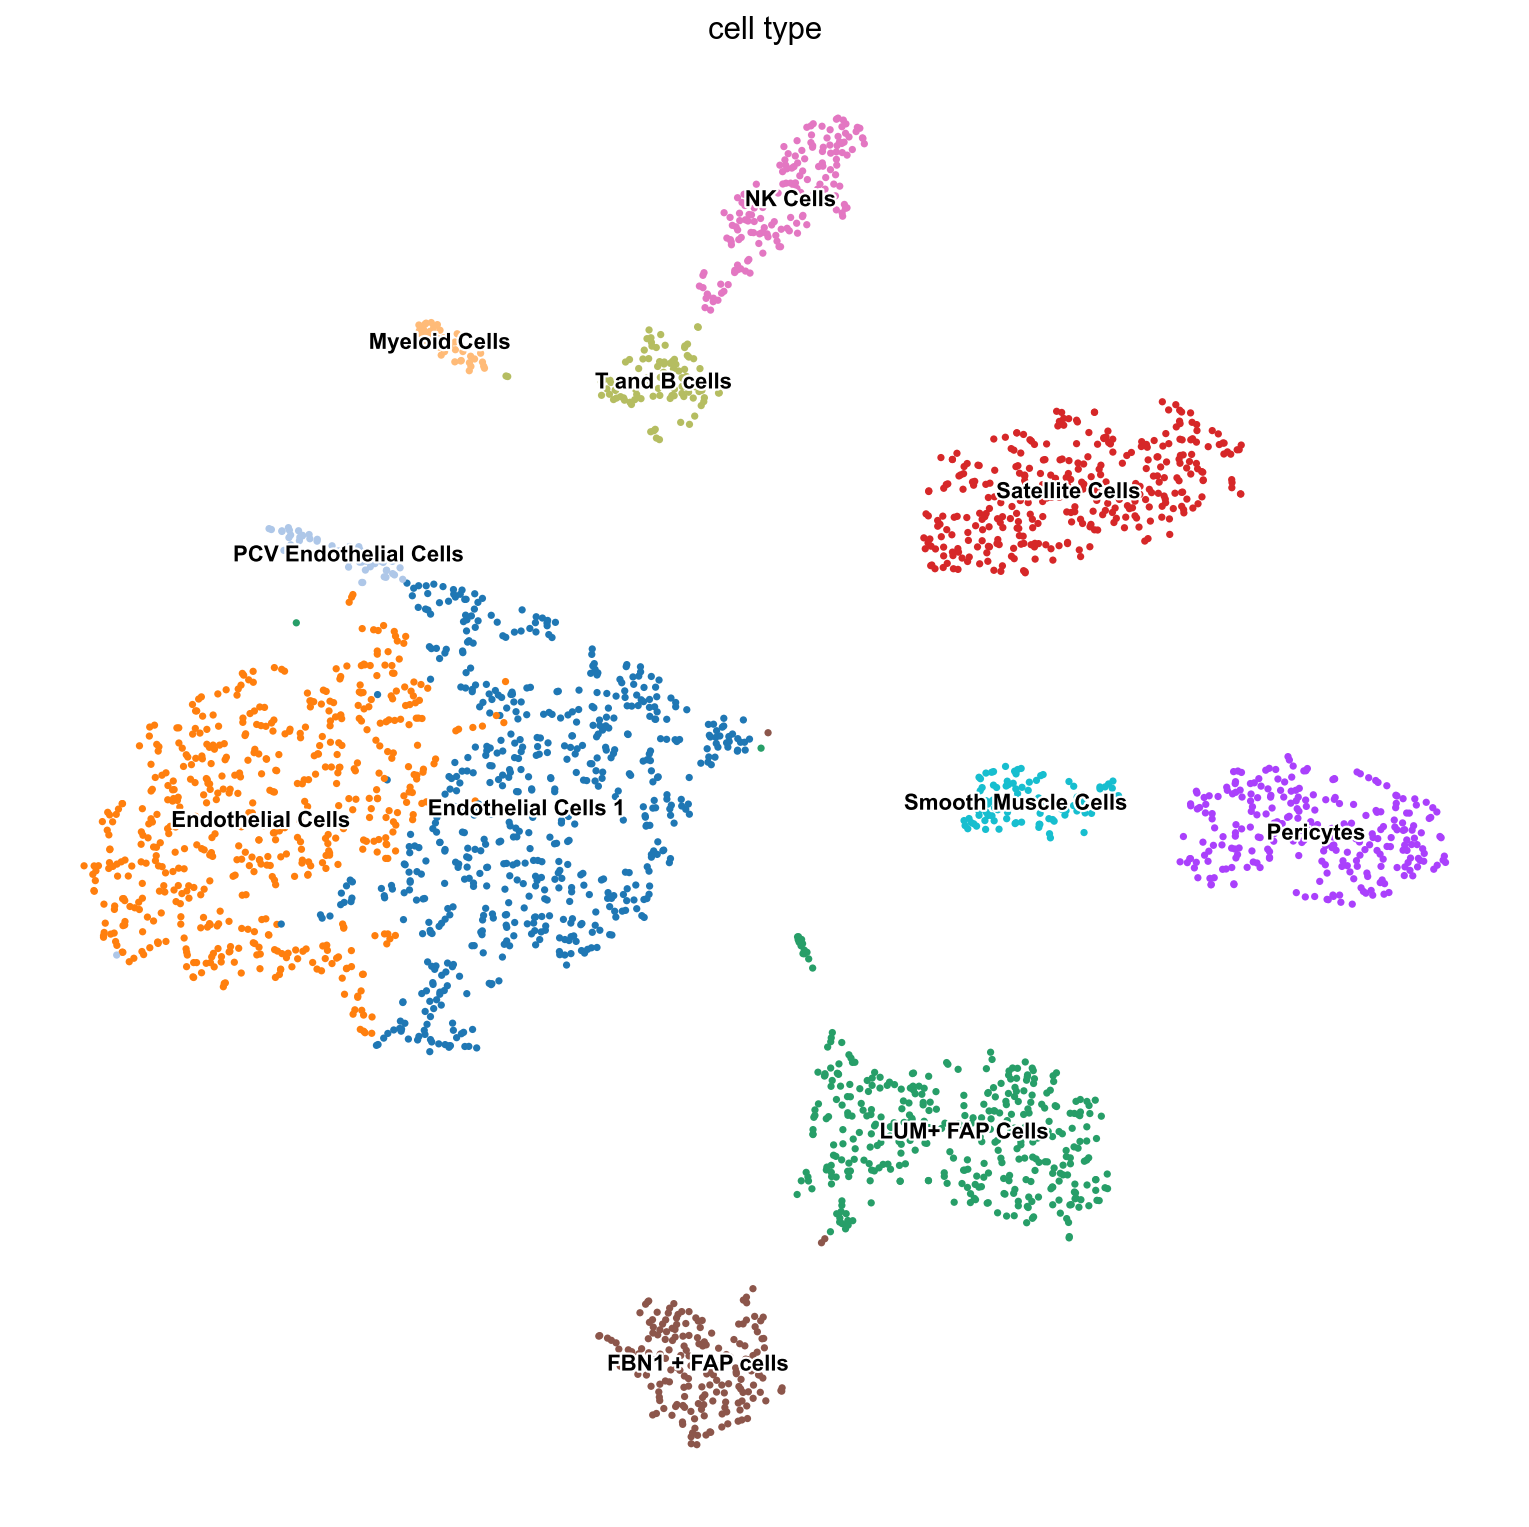

In [115]:
 sc.pl.tsne(adata, color='cell type', legend_loc='on data',
           frameon=False, legend_fontsize=10, legend_fontoutline=2)

In [105]:
adata.obs

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,clusters,cell type,cell_type,pearson_correlation,cell-cell_correlation
1_AAACGGGGTCCAGTAT,295,295,765.0,35.0,4.575163,4,Pericytes,Pericytes,4.575163,4.575163
1_AAACGGGTCGGCTTGG,443,443,1150.0,35.0,3.043478,1,endothelial cells 1,endothelial cells 1,3.043478,3.043478
1_AAAGATGAGCAATATG,1129,1129,5075.0,96.0,1.891626,0,endothelial cells,endothelial cells,1.891626,1.891626
1_AAAGATGGTCAAAGCG,734,734,2391.0,22.0,0.920117,2,LUM+FAP Cells,LUM+FAP Cells,0.920117,0.920117
1_AAAGTAGCAGCGTCCA,1016,1016,4221.0,181.0,4.288083,8,T and B cells,T and B cells,4.288083,4.288083
...,...,...,...,...,...,...,...,...,...,...
4_TTGTAGGTCTCTAAGG,633,633,1825.0,62.0,3.397260,2,LUM+FAP Cells,LUM+FAP Cells,3.397260,3.397260
4_TTTACTGAGACTGTAA,384,384,2065.0,54.0,2.615012,7,PCV Endothelial Cells,PCV Endothelial Cells,2.615012,2.615012
4_TTTACTGTCAGCCTAA,544,544,1354.0,58.0,4.283604,1,endothelial cells 1,endothelial cells 1,4.283604,4.283604
4_TTTCCTCAGGTGGGTT,267,267,904.0,4.0,0.442478,0,endothelial cells,endothelial cells,0.442478,0.442478


# 4. Heatmap

categories: endothelial cells, endothelial cells 1, LUM+FAP Cells, etc.
var_group_labels: Endothelial Cells, Endothelial Cells 1, LUM+ FAP Cells, etc.


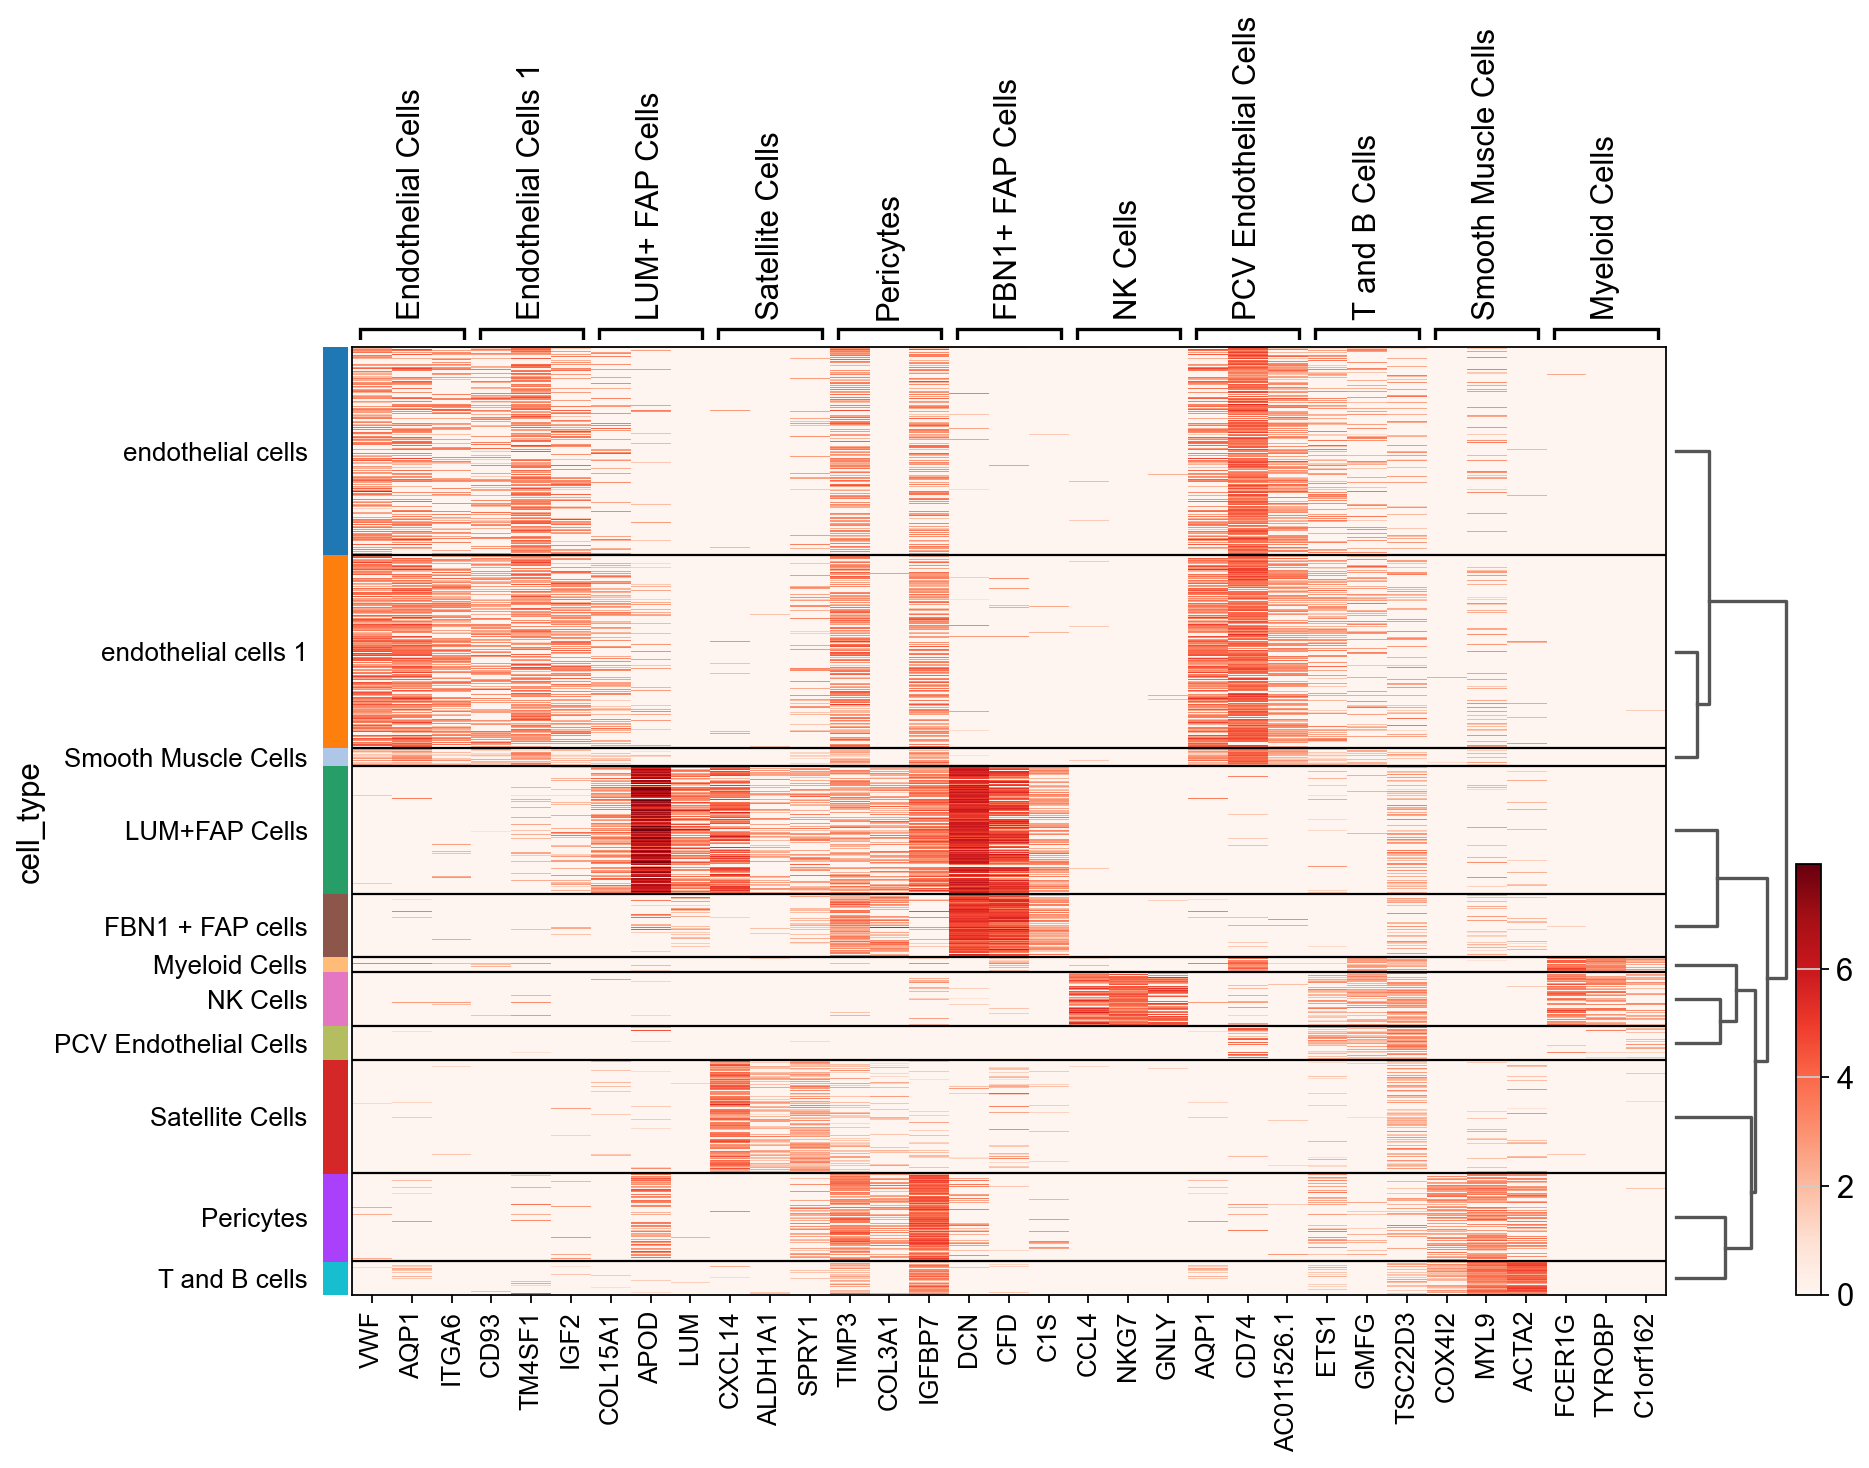

In [125]:
sc.pl.heatmap(adata, marker_genes_dict, groupby='cell_type', cmap='Reds', dendrogram=True, figsize=(12, 8))